# Bounding Box: Visualização e Detecção

## Importação das bibliotecas

In [1]:
!wget -q https://raw.githubusercontent.com/robertoalotufo/ia368z/master/PyTorch/lib/pytorch_trainer_v2.py -Plib/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from IPython import display

import os
import json
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim.lr_scheduler
import torchvision

from lib import pytorch_trainer_v2 as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Dataset

O dataset escolhido foi o [Street View Hous Numbers Dataset](http://ufldl.stanford.edu/housenumbers/), contendo os dados já pré-separados em pastas de treinamento e teste.

In [41]:
def oneHotPixelMatrix(num_classes, image_size, image_data, count_background=True):
    total_classes = num_classes+1 if count_background else num_classes
    one_hot_matrix = torch.zeros((total_classes, image_size[1], image_size[0]), dtype=torch.int)

    if count_background:
        one_hot_matrix[num_classes,:,:] = 1

    for entry in image_data:
        entry_label = int(entry['label'])
        entry_range = [int(np.floor(entry['bbox'][0])), int(np.floor(entry['bbox'][1])),
                       int(np.ceil(entry['bbox'][0] + entry['bbox'][2])),
                       int(np.ceil(entry['bbox'][1] + entry['bbox'][3]))]

        one_hot_matrix[entry_label, entry_range[1]:entry_range[3], entry_range[0]:entry_range[2]] = 1

        if count_background:
            one_hot_matrix[num_classes, entry_range[1]:entry_range[3], entry_range[0]:entry_range[2]] = 0

    return one_hot_matrix

def imageDataFromOneHot(onehot_matrix, count_background=True):
    fd = list()

    total_classes = onehot_matrix.shape[0]-1 if count_background else onehot_matrix.shape[0]
    onehot_matrix_row_sum = onehot_matrix[:total_classes].sum(1)
    onehot_matrix_col_sum = onehot_matrix[:total_classes].sum(2)

    onehot_matrix_sum = onehot_matrix_row_sum.sum(1)
    for idx in range(total_classes):
        if onehot_matrix_sum[idx] != 0.0:
            bbox_heights = torch.unique(onehot_matrix_row_sum[idx])
            bbox_widths = torch.unique(onehot_matrix_col_sum[idx])
            height_list = bbox_heights[bbox_heights.nonzeros()].tolist()
            width_list = bbox_widths[bbox_widths.nonzeros()].tolist()
            
            if 
            fd.append(dict(label=str(idx), ))

In [49]:
class SVHNDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, size=None, onehot=False):
        if train:
            path = os.path.join(rootdir, 'train')
        else:
            path = os.path.join(rootdir, 'test')

        self.size = size
        if self.size is None:
            self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        else:
            self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=self.size[::-1]),
                                                             torchvision.transforms.ToTensor()])

        self.onehot = onehot

        file_list = [file_name for file_name in os.listdir(path) if file_name.endswith('.png')]
        file_data = None
        for entry in os.listdir(path):
            if entry.endswith('.json'):
                file_data_obj = open(os.path.join(path, entry), 'r')
                file_data = json.load(file_data_obj)
                file_data_obj.close()
                break

        self.file_path_list = [os.path.join(path, file_name) for file_name in file_list]

        self.file_data_list = list()
        for file_name in file_list:
            data_list = list()
            for entry in file_data[file_name]:
                data_list.append(dict(bbox=[entry['left'], entry['top'], entry['width'], entry['height']],
                                      label=(entry['label'] if entry['label'] != 10 else 0)))
            self.file_data_list.append(data_list)

    def __len__(self):
        return len(self.file_path_list)

    def __getitem__(self, index):
        if type(index) is int:
            fp = self.file_path_list[index]
            fd = self.file_data_list[index]
        else:
            fp = self.file_path_list[index][0]
            fd = self.file_data_list[index][0]

        inp = PIL.Image.open(fp)

        if self.size is not None:
            new_fd = list()
            size_ratio = np.array(self.size) / np.array(inp.size)
            for entry in fd:
                bbox = entry['bbox']
                new_bbox = [bbox[0]*size_ratio[0], bbox[1]*size_ratio[1],
                            bbox[2]*size_ratio[0], bbox[3]*size_ratio[1]]
                new_fd.append(dict(bbox=new_bbox, label=entry['label']))
            fd = new_fd

        inp = self.transform(inp)

        if self.onehot:
            if self.size is not None:
                return inp, oneHotPixelMatrix(10, self.size, fd)
            else:
                return inp, oneHotPixelMatrix(10, inp.size, fd)
        else:
            return inp, fd

## Padronização dos dados

In [50]:
dataset_path = '/home/adriano/Documentos/Mestrado/IA376F_Redes_Neurais_Leitura_Robusta/aula04/SVHN'

In [51]:
dataset_viz_train = SVHNDataset(dataset_path, train=True)
dataset_viz_test = SVHNDataset(dataset_path, train=False)

In [52]:
def vizNumbers(dataset, num_imgs=5):
    img_list = list()
    dat_list = list()
    toPIL = torchvision.transforms.ToPILImage()

    for idx in range(num_imgs):
        dataset_entry = dataset[idx]
        img_list.append(toPIL(dataset_entry[0]))
        dat_list.append(dataset_entry[1])

    fig = plt.figure(figsize=(11, 4), dpi=100)
    for idx, img in enumerate(img_list):
        ax = fig.add_subplot(1, num_imgs, 1 + idx)
        ax.imshow(img)

        for entry in dat_list[idx]:
            ax.add_patch(patches.Rectangle(entry['bbox'][:2], entry['bbox'][2], entry['bbox'][3],
                                           fill=False, edgecolor='blue', lw=2))

        img_label = ''.join([str(entry['label']) for entry in dat_list[idx]])
        ax.set_title(f'{img_label} - {img.size}')
        ax.axis('off')
    plt.show()

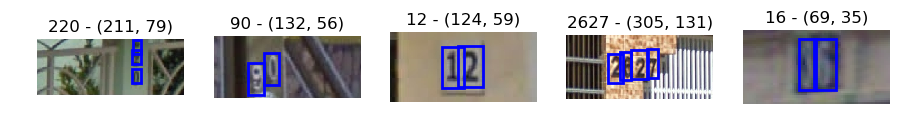

In [53]:
vizNumbers(dataset_viz_train)

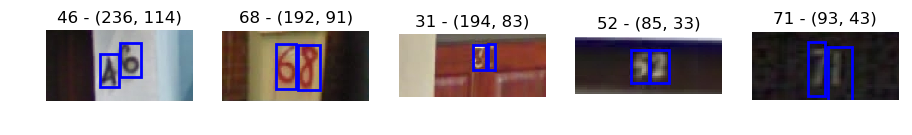

In [36]:
vizNumbers(dataset_viz_test)

## Padronização dos dados

In [37]:
dataset_train = SVHNDataset(dataset_path, train=True, size=(120, 60))
dataset_test = SVHNDataset(dataset_path, train=False, size=(120, 60))

Formato do dado de treinamento: torch.Size([3, 60, 120])


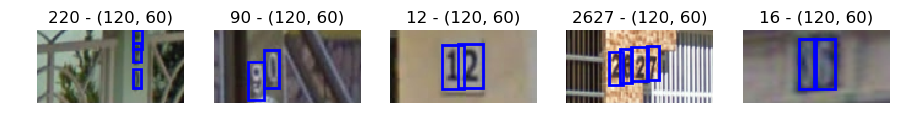

In [38]:
print(f'Formato do dado de treinamento: {dataset_train[0][0].shape}')
vizNumbers(dataset_train)

Formato do dado de teste: torch.Size([3, 60, 120])


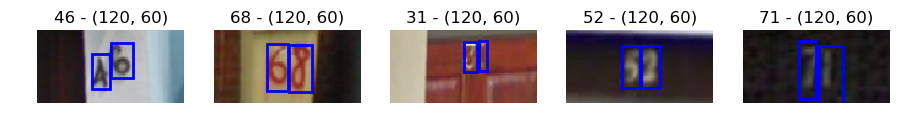

In [40]:
print(f'Formato do dado de teste: {dataset_test[0][0].shape}')
vizNumbers(dataset_test)

## Padronização dos rótulos (labels)

Para a localização simultânea de multiplos números (detecção de bounding boxes e classificação), é proposta uma codificação do rótulo na forma de one-hot 3-D, na qual são geradas matrizes com as mesmas dimensões da imagem, mais a dimensão de profundidade igual ao número de classes mais uma camada para marcar o background.

Formato reduzido dos dados para testar o One Hot encoding: torch.Size([3, 6, 12])


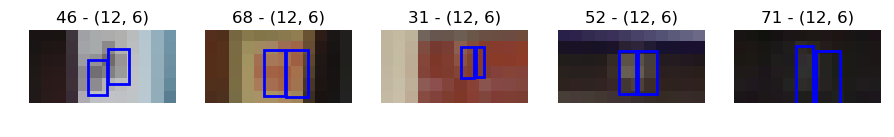

In [42]:
dataset_label = SVHNDataset(dataset_path, train=False, size=(12, 6))
print(f'Formato reduzido dos dados para testar o One Hot encoding: {dataset_label[0][0].shape}')
vizNumbers(dataset_label)

In [43]:
oneHotPixelMatrix(num_classes=10, image_size=(12,6), image_data=dataset_label[0][1])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Definição da rede

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 4))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4))
        self.maxp = nn.MaxPool2d(kernel_size=(2, 2))

        self.dens1 = nn.Linear(in_features=64*13*5, out_features=64)
        self.drop1 = nn.Dropout(0.5)
        self.dens2 = nn.Linear(in_features=64, out_features=4)

    def forward(self, x):        # input:  amostras x  3 x 120 x 60
        x = self.conv1(x)        # output: amostras x 32 x 118 x 58
        x = F.relu(x)
        x = self.maxp(x)         # output: amostras x 32 x  59 x  27

        x = self.conv2(x)        # output: amostras x 32 x  56 x  24
        x = F.relu(x)
        x = self.maxp(x)         # output: amostras x 32 x  28 x  12

        x = self.conv3(x)        # output: amostras x 64 x  26 x  10
        x = F.relu(x)
        x = self.maxp(x)         # output: amostras x 64 x  13 x  5

        x = self.conv4(x)        # output: amostras x 64 x  10 x  2
        x = F.relu(x)

        x = x.view(-1, 64*13*5) # output: amostras x (64 * 13 * 5)
        x = self.dens1(x)        # output: amostras x 64
        x = F.relu(x)
        x = self.drop1(x)
        x = self.dens2(x)        # output: amostras x 2

        return x.view(-1, 2)     # output: amostras x 1 x 2

## Instanciando o modelo que usará aumento sintético de dados

In [ ]:
model_augm = MyModel()
if use_gpu:
    model_augm = model_augm.cuda()
    print('Using GPU')
else:
    print('Using CPU')

In [ ]:
ex_input = dataset_train[0:1][0].unsqueeze(0).cuda(async=True)
y_pred = model_augm(ex_input)

## Treinamento

In [ ]:
n_epochs = 100
optm = torch.optim.Adam(params=model_augm.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
#cb_chkpt = ptt.ModelCheckpoint('data_augmentation_catsdogs', reset=True, verbose=1)

trainer_augm = ptt.DeepNetTrainer(model         = model_augm,
                                  criterion     = nn.CrossEntropyLoss(),
                                  optimizer     = optm,
                                  lr_scheduler  = schd,
                                  callbacks = [ptt.AccuracyMetric(), 
                                               ptt.PrintCallback(),
                                               #cb_chkpt
                                              ])

In [ ]:
train = True
if train:
    trainer_augm.fit_loader(n_epochs, loader_train, valid_data=loader_valid)
else:
    trainer_augm.load_state('/data/models/data_augmentation_catsdogs')

In [ ]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

In [ ]:
show_history(trainer_augm)

## Aprendizados com este notebook



1. A padronização de dados geométricos (bounding box) traz uma dificuldade a mais na normalização dos dados, pois o bounding box pode ficar distorcido com as transformações aplicadas à imagem original